In [39]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import gc; gc.collect()

from   pathlib  import Path
from time                    import time

from scipy.signal            import argrelmin, argrelmax

from sklearn.linear_model    import LogisticRegression
from category_encoders       import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline        import make_pipeline, Pipeline
from sklearn.preprocessing   import KBinsDiscretizer, FunctionTransformer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute          import SimpleImputer

from symbols                import BUY_THRESHOLD

import warnings
warnings.filterwarnings("ignore")

In [3]:
YFLOAD_PATH = '/Users/frkornet/CDA/Project/stockie/data/yfin/'
TRADE_PERIOD    = "10y"
NAME_MAP        = f'/Users/frkornet/CDA/Project/fund_indicators/name_map.csv'

In [4]:
def get_stock_n_smooth(ticker, period):
    """
    Copy of what is in util.py. Except this version reads what has been read 
    from yfinance and stored on file. The stored version is smoothed already, 
    and reading from disk should be much faster as it avoids the expensive 
    smoothing operation. The reading from file, will only return success if 
    there is at least 5 years worth of data to work with. 
    """
    gc.collect()
    try:
       hist = pd.read_csv(f'{YFLOAD_PATH}{ticker}.csv')
       hist.index = hist.Date.values
       del hist['Date']
       success = len(hist) > 5 * 252
       print(f'Successfully retrieved smoothed price data for {ticker} '+
             f'(len(hist)={len(hist)}, success={success})')
    except:
       hist = None
       success = False
       print(f'Failed to find {ticker}.csv in {YFLOAD_PATH}!')
    
    return success, hist

In [5]:
ticker = 'AFG'
target = 'target'
success, hist = get_stock_n_smooth(ticker, TRADE_PERIOD)
assert success == True, "Unable to get historical price data and smooth price!"
hist[target] = 0
hist

Successfully retrieved smoothed price data for AFG (len(hist)=2517, success=True)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth,P/E Ratio,target
2011-02-14,24.07,24.07,23.82,23.87,335600,0.0,0,23.960931,NaN,0
2011-02-15,23.83,23.99,23.77,23.93,389600,0.0,0,23.967712,NaN,0
2011-02-16,23.95,24.14,23.95,24.06,242100,0.0,0,23.974493,NaN,0
2011-02-17,24.02,24.34,23.98,24.33,190400,0.0,0,23.981275,NaN,0
2011-02-18,24.36,24.49,24.23,24.48,226900,0.0,0,23.988056,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2021-02-08,100.52,103.36,100.51,103.04,863800,0.0,0,98.591670,36.931900,0
2021-02-09,102.83,105.09,102.25,104.34,498400,0.0,0,99.205907,37.397849,0
2021-02-10,104.89,107.42,103.97,106.44,961700,0.0,0,99.820145,38.150538,0
2021-02-11,106.16,108.30,106.00,108.03,521700,0.0,0,100.434382,38.720430,0


In [6]:
hist_orig = pd.read_csv('/Users/frkornet/CDA/Project/stockie/data/yfin_bak/ABCB.csv')
hist_orig.index = hist_orig.Date.values
del hist_orig['Date']
hist_orig

,Open,High,Low,Close,Volume,Dividends,Stock Splits,smooth
2011-02-14,9.17,9.38,9.16,9.31,18700,0.0,0,9.205647
2011-02-15,9.24,9.34,9.14,9.22,15700,0.0,0,9.203333
2011-02-16,9.23,9.31,9.15,9.17,13800,0.0,0,9.201019
2011-02-17,9.19,9.19,9.03,9.10,60800,0.0,0,9.198705
2011-02-18,9.19,9.26,9.14,9.24,48300,0.0,0,9.196392
...,...,...,...,...,...,...,...,...
2021-02-08,44.38,45.14,43.70,45.08,293600,0.0,0,44.230497
2021-02-09,45.00,45.73,44.38,45.51,551400,0.0,0,44.372137
2021-02-10,45.70,46.98,45.30,46.09,424600,0.0,0,44.513778
2021-02-11,46.05,46.58,44.68,45.66,317500,0.0,0,44.655419


In [7]:
def features(data, target):
    """ 
    Given a standard yfinance data dataframe, add features that will help
    the balanced scorecard to recognize buy and sell signals in the data.
    The features are added as columns in the data dataframe. 
    
    The original hist dataframe from yfinance is provided, so we can copy
    the target to the data dataframe. The data dataframe with the extra 
    features is returned. The target argument contains the name of the 
    column that contains the the target.
    """
    windows = [3, 5, 10, 15, 20, 30, 45, 60] 

    for i in windows:
        ma = data.Close.rolling(i).mean()
        # Moving Average Convergence Divergence (MACD)
        data[f'MACD_{i}']    = ma - data.Close
        data[f'PctDiff_{i}'] = data.Close.diff(i)
        data[f'StdDev_{i}']  = data.Close.rolling(i).std()


    exclude_cols = [target, 'smooth', 'Close', 'Date', 'Volume', 'Dividends', 'Stock Splits'] 
    factor = data.Close.copy()
    for c in data.columns.tolist():
        if c in exclude_cols:
           continue
        data[c] = data[c] / factor

    for i in windows:
        #data[f'RSI_{i}']     = RSI(data, i)
        #data[f'WPR_{i}']     = WPR(data, i)
        #data[f'MFI_{i}']     = MFI(data, i)
        data[f'BBP_{i}']      = BBP(data, i)
        
    data = data.dropna()
    
    return data

In [8]:
def RSI_Frank(df, window):
    price = hist['Close']
    rsi = price.copy()
    
    daily_rets = price.copy()
    daily_rets.values[1:] = price.values[1:] - price.values[:-1]
    daily_rets.values[0]  = np.nan

    up_rets = price.copy()
    up_rets[:] = np.nan
    up_rets[daily_rets >= 0] = daily_rets[daily_rets >= 0]
    up_rets = up_rets.fillna(0).cumsum()
    
    down_rets = price.copy()
    down_rets[:] = np.nan
    down_rets[daily_rets <  0] = -daily_rets[daily_rets <  0] # .fillna(0).cumsum() * -1.0
    down_rets = down_rets.fillna(0).cumsum() 
    
    up_gain = price.copy()
    up_gain[:window] = 0
    up_gain.values[window:] = up_rets.values[window:] - up_rets.values[:-window]

    down_loss = price.copy()
    down_loss.iloc[:window] = 0 
    down_loss.values[window:] = down_rets.values[window:] - down_rets.values[:-window]
    
    rs = (up_gain / window) / (down_loss / window)
    
    rsi = 100 - (100 / (1 + rs))
    rsi.iloc[:window] = np.nan

    rsi[rsi == np.inf] == 100 
    return rsi 

In [9]:
def RSI_Harshad(df, window):
    Gain=df['Close'].copy()
    Loss=df['Close'].copy()
    Avg_gain=df['Close'].copy()
    Avg_loss=df['Close'].copy()
    rsi=df['Close'].copy()

    Gain[:]=0.0
    Loss[:]=0.0
    Avg_gain[:]=0.0
    Avg_loss[:]=0.0
    rsi[:]=np.nan

    for i in range(1,len(df)):
        if df.Close.iloc[i] > df.Close.iloc[i-1]:
            Gain[i]=df.Close.iloc[i]-df.Close.iloc[i-1]
        else:
            # For loss save the absolute value on loss
            Loss[i]=abs(df.Close.iloc[i]-df.Close.iloc[i-1])
        if i>window:
            Avg_gain[i]=(Avg_gain[i-1]*(window-1)+Gain[i])/window
            Avg_loss[i]=(Avg_loss[i-1]*(window-1)+Loss[i])/window
            rsi[i]=(100*Avg_gain[i]/(Avg_gain[i]+Avg_loss[i])).round(2)

    return rsi

In [10]:
def RSI(df, window):
    return RSI_Frank(df, window)

In [11]:
def WPR(df, window):

    Highest_High = df['High'].rolling(window,min_periods=window).max()
    Lowest_Low   = df['Low'].rolling(window,min_periods=window).min()
    
    denom = (Highest_High - Lowest_Low).values
    denom[denom == 0] = 0.00001
    wpr = 100 * (df['Close'] - Highest_High) / denom

    return wpr

In [12]:
def MFI(df, window):

    typical_price = (df['High'] + df['Low'] + df['Close'])/3
    raw_money_flow = typical_price*df['Volume']

    idx = typical_price>typical_price.shift(1)

    pos_money_flow = raw_money_flow.copy()
    pos_money_flow.iloc[:] = 0.0
    pos_money_flow.loc[idx] = raw_money_flow.loc[idx]

    neg_money_flow = raw_money_flow.copy()
    neg_money_flow.iloc[:] = 0.0
    neg_money_flow.loc[~idx] = raw_money_flow.loc[~idx]

    mfi_pos = pos_money_flow.rolling(window).sum()
    mfi_neg = neg_money_flow.rolling(window).sum()
    
    denom = (mfi_pos+mfi_neg).values
    denom[denom == 0] = 0.00001
    mfi = 100 * mfi_pos / denom

    return mfi

In [13]:
def BBP(df, window):   
    MA=df['Close'].rolling(window).mean()
    Std_Dev=df['Close'].rolling(window).std()

    BOLU=MA+2*Std_Dev
    BOLL=MA-2*Std_Dev

    denom = (BOLU - BOLL).values
    denom[denom == 0.0] = 0.00001
    # bbp = ( df['Close'] - BOLL) / (BOLU - BOLL)
    bbp = ( df['Close'] - BOLL) / denom
    
    return bbp

In [14]:
BBP(hist,3)

2011-02-14         NaN
2011-02-15         NaN
2011-02-16    0.774559
2011-02-17    0.773636
2011-02-18    0.723174
                ...   
2021-02-08    0.738541
2021-02-09    0.713317
2021-02-10    0.767154
2021-02-11    0.737727
2021-02-12    0.645693
Name: Close, Length: 2517, dtype: float64

In [15]:
def log(a):
    print(a)

In [16]:
def stringify(data):
    """
    Convert a Pandas dataframe with numeric columns into a dataframe with only
    columns of the data type string (in Pandas terminology an object). The 
    modified dataframe is returned. Note that the original dataframe is lost.
    """
    df = pd.DataFrame(data)
    for c in df.columns.tolist():
        df[c] = df[c].astype(str)
    return df

In [17]:
def split_data(stock_df, used_cols, target, train_pct):
    """
    Split data set into a training and test data set:
    - X contains the features for training and predicting. 
    - y contains the target for training and evaluating the performance.

    Used_cols contain the features (i.e. columns) that you want to use
    for training and prediction. Target contains the name of the column
    that is the target.

    Function returns X and y for cross validation, X and y for training, 
    and X and y for testing.
    """

    test_starts_at = int(len(stock_df)*train_pct)
    X = stock_df[used_cols]
    y = stock_df[target]

    X_train = stock_df[used_cols].iloc[:test_starts_at]
    X_test  = stock_df[used_cols].iloc[test_starts_at:]
    y_train = stock_df[target].iloc[:test_starts_at]
    y_test  = stock_df[target].iloc[test_starts_at:]

    return X, y, X_train, X_test, y_train, y_test

In [18]:
def get_signals(X_train, y_train, X_test, threshold):
    """
    Used to predict buy and sell signals. The function itself has no awareness
    what it is predicting. It is just a helper function used by 
    get_possible_trades().

    Target is the column that contains the target. The other columns are
    considered to be features to be used for training and prediction.

    The function uses a balanced weight of evidence scorecard to predict the 
    signals. It returns the signals array.

    Note that the function uses 70% for training and 30% for testing. The 
    date where the split happens is dependent on how much data the hist
    dataframe contains. So, the caller will not see a single split date for
    all tickers. 
    """

    scaler    = StandardScaler()
    encoder   = WOEEncoder()
    binner    = KBinsDiscretizer(n_bins=5, encode='ordinal')
    objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
    imputer   = SimpleImputer(strategy='constant', fill_value=0.0)
    clf       = LogisticRegression(class_weight='balanced', random_state=42)

    pipe = make_pipeline(scaler, binner, objectify, encoder, imputer, clf)
    pipe.fit(X_train, y_train.values)

    test_signals = (pipe.predict_proba(X_test)  > threshold).astype(int)[:,1]
    return y_train.values, test_signals.copy()

In [19]:
def merge_buy_n_sell_signals(buy_signals, sell_signals):
    """
    The functions will take two lists and produce a single list containing the 
    buy and sell signals. The merged list will always start with a buy signal.
    This is achieved by setting the state to SELL. That ensures that all sell 
    signals are quietly dropped until we get to the first buy signal.

    Note: this function does not enforce that each buy signal is matched with  
    a sell signal.

    The function implements a simple deterministic state machine that flips 
    from SELL to BUY and back from BUY to SELL.

    A buy in the merged list is 1 and a sell is 2. The merged list is
    returned to the caller at the end.
    """

    assert len(buy_signals) == len(sell_signals), "buy_signal and sell_signal lengths different!"
    log(f'type(buy_signals) ={type(buy_signals)} len()={len(buy_signals)}')
    log(f'type(sell_signals)={type(sell_signals)} len()={len(sell_signals)}')

    buy_n_sell = np.zeros((len(buy_signals),), dtype=int)
    length     = len(buy_n_sell)
    i          = 0
    state      = SELL

    buy_ids  = np.where(buy_signals != 0)[0].tolist()
    sell_ids = np.where(sell_signals != 0)[0].tolist()
    log(f'merge_buy_n_sell_signals():')
    log(f'- buy_ids ={buy_ids} len()={len(buy_ids)}')
    log(f'- sell_ids={sell_ids} len()={len(sell_ids)}')
    
    while i < length:
        if state == SELL and buy_signals[i] == 1:
            state = BUY
            buy_n_sell[i] = 1

        elif state == BUY and sell_signals[i] == 1:
            state = SELL
            buy_n_sell[i] = 2
            #continue

        i = i + 1

    buy_n_sell_ids  = np.where(buy_n_sell != 0)[0].tolist()
    log(f'- buy_n_sell_ids ={buy_n_sell_ids} len()={len(buy_n_sell_ids)}')
    return buy_n_sell

In [20]:
def extract_trades(hist, buy_n_sell, start_at, ticker, verbose):
    #test_start_at = len(hist) - len(buy_n_sell)
    log(f'extract_trades():')
    log(f'- len(hist)={len(hist)}')
    log(f'- len(buy_n_sell)={len(buy_n_sell)}')
    log(f'- start_at={start_at}')
    #test_start_at = 0

    cols = ['buy_date', 'buy_close', 'sell_date', 'sell_close', 'gain_pct',
            'trading_days', 'daily_return', 'ticker' ]
    possible_trades_df = pd.DataFrame(columns=cols)

    buy_id = sell_id = -1

    for i, b_or_s in enumerate(buy_n_sell):

        if b_or_s == BUY:
            buy_id    = start_at + i
            buy_close = hist.Close.iloc[buy_id]
            buy_date  = hist.index[buy_id]

        if b_or_s == SELL:
            sell_id    = start_at + i
            sell_close = hist.Close.iloc[sell_id]
            sell_date  = hist.index[sell_id]

            gain = sell_close - buy_close
            gain_pct = round( (gain / buy_close)*100, 2)

            trading_days = sell_id - buy_id

            daily_return = (1+gain_pct/100) ** (1/trading_days) - 1
            daily_return = round(daily_return * 100, 2)

            trade_dict = {'buy_date'    : [buy_date],  'buy_close'    : [buy_close],
                         'sell_date'    : [sell_date], 'sell_close'   : [sell_close],
                         'gain_pct'     : [gain_pct],  'trading_days' : [trading_days],
                         'daily_return' : [daily_return], 'ticker'    : [ticker] }
            possible_trades_df = pd.concat([possible_trades_df,
                                           pd.DataFrame(trade_dict)])
    
    if verbose == True:
        log("****EXTRACT_TRADES****")
        log(possible_trades_df)

    if buy_id > 0 and buy_id > sell_id:
        buy_opportunity_df = {'ticker'    : [ticker] ,
                              'buy_date'  : [buy_date],
                              'buy_close' : [buy_close],
                             }
        buy_opportunity_df = pd.DataFrame(buy_opportunity_df)
    else:
        cols=['ticker', 'buy_date', 'buy_close']
        buy_opportunity_df = pd.DataFrame(columns=cols)

    return possible_trades_df, buy_opportunity_df


In [21]:
def pair_buy_n_sell_signals(min_ids, max_ids):

    length_i, length_j = len(min_ids), len(max_ids)
    bns_pairs = []
    i, j = 0, 0

    while i < length_i and j < length_j:
       # log(f'i={i} j={j} length_i={length_i} length_j={length_j} bns_pairs={bns_pairs}')
       # log(f'min_ids[i]={min_ids[i]} max_ids[j]={max_ids[j]}')
       if min_ids[i] >= max_ids[j]:
          j += 1
       else:
          bns_pairs.append((min_ids[i], max_ids[j]))
          i += 1
          j += 1

    return bns_pairs

In [22]:
def process_bns_pairs(hist, bns_pairs, verbose=False):

    range_min, range_plus = -3, 3
    min_ids, max_ids, drets = [], [], []
    for (s,e) in bns_pairs:
        if verbose: log(f's={s}, e={e}')
        start_values = [s+i for i in range(range_min, range_plus+1)
                        if s+i > 0 and s+i < len(hist)]
        if verbose: log(f'start_values={start_values}')
        end_values = [e+i for i in range(range_min, range_plus+1)
                        if s+i > 0 and s+i < len(hist)]
        if verbose: log(f'end_values={end_values}')

        best_s = best_e = best_dret = None
        for si in start_values:
            for ei in end_values:
                days = ei - si
                if verbose: log(f"- days={days}")
                if days < 5 or days > 50:
                   continue

                si_close = hist.Close.iloc[si]
                ei_close = hist.Close.iloc[ei]
                gain    = ei_close - si_close
                if verbose: log(f"- gain={gain}")
                if gain <= 0.0:
                   continue

                dret = (1 + gain/si_close) ** (1/days) - 1.0
                if verbose: log(f"- dret={dret}")
                if best_dret is None or dret > best_dret:
                   best_s, best_e, best_dret = si, ei, dret
                if verbose: log(f"- best_s={best_s} best_e={best_e} best_dret={best_dret}")

        if best_dret is not None and best_dret >= 0.003:
           if verbose: log(f"adding {best_s}, {best_e}, {best_dret} to lists")
           min_ids.append(best_s)

    log(f'process_bns_pairs(): min_ids={min_ids}')
    log(f'process_bns_pairs(): max_ids={max_ids}')
    log(f'process_bns_pairs(): drets={drets}')
    return min_ids, max_ids

In [23]:
ticker = 'NTUS'
success, hist = get_stock_n_smooth(ticker, TRADE_PERIOD)
if success == False:
   assert 1 == 2, "Error!"

secs = []

# pre-process data, create features, and split data
start_time = time()
step = "pre-process"
target = 'target'
hist[target] = 0
hist = features(hist, target)
exclude_cols = [target, 'smooth', 'Close', 'Date', 'Volume', 'Dividends', 'Stock Splits']
used_cols = [c for c in hist.columns.tolist() if c not in exclude_cols]
X, y, X_train, X_test, y_train, y_test = split_data(hist, used_cols, target, 0.7)
y_train_len = len(y_train)
secs.append(time() - start_time)

# pre-process data, create features, and split data
start_time = time()
step = "local minima/maxima"
min_ids = argrelmin(hist.smooth.values)[0].tolist()
max_ids = argrelmax(hist.smooth.values)[0].tolist()
del hist['smooth']
bns_pairs = pair_buy_n_sell_signals(min_ids, max_ids)
new_min_ids, new_max_ids = process_bns_pairs(hist, bns_pairs)
log(f"- len(min_ids)      ={len(min_ids)}")
log(f"- len(max_ids)      ={len(max_ids)}")
log(f"- len(bns_pairs)    ={len(bns_pairs)}")
log(f"- bns_pairs         ={bns_pairs}")
log(f"- len(new_min_ids)  ={len(new_min_ids)}")
log(f"- len(new_max_ids)  ={len(new_max_ids)}")
min_ids, max_ids = new_min_ids, new_max_ids
log(f"- min_ids           ={min_ids}")
log(f"- max_ids           ={max_ids}")
secs.append(time() - start_time)

# get the buy signals
start_time = time()
step = "get buy signals"
hist[target] = 0
hist[target].iloc[min_ids] = 1
y_train = hist[target].iloc[0:y_train_len].copy()
#train_buy_signals, test_buy_signals = \
#    get_signals(X_train, y_train, X_test, BUY_THRESHOLD)
# test_buy_signals += len(train_buy_signals)
#secs.append(time() - start_time)

Successfully retrieved smoothed price data for NTUS (len(hist)=2517, success=True)
process_bns_pairs(): min_ids=[355, 409, 500, 599, 721, 776, 923, 984, 1207, 1282, 1395, 1437, 1491, 1557, 1639]
process_bns_pairs(): max_ids=[]
process_bns_pairs(): drets=[]
- len(min_ids)      =21
- len(max_ids)      =21
- len(bns_pairs)    =20
- bns_pairs         =[(152, 337), (352, 387), (406, 461), (497, 550), (596, 615), (650, 713), (718, 753), (773, 783), (822, 845), (851, 882), (920, 951), (983, 1032), (1095, 1180), (1206, 1236), (1283, 1323), (1392, 1412), (1438, 1487), (1489, 1536), (1556, 1582), (1638, 1650)]
- len(new_min_ids)  =15
- len(new_max_ids)  =0
- min_ids           =[355, 409, 500, 599, 721, 776, 923, 984, 1207, 1282, 1395, 1437, 1491, 1557, 1639]
- max_ids           =[]


In [24]:
scaler    = StandardScaler()
encoder   = WOEEncoder()
binner    = KBinsDiscretizer(n_bins=5, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
imputer   = SimpleImputer(strategy='constant', fill_value=0.0)
clf       = LogisticRegression(class_weight='balanced', random_state=42)

# pipe = make_pipeline(scaler, binner, objectify, encoder, imputer, clf)
pipe = make_pipeline(scaler, binner, objectify, encoder, imputer, clf)

In [25]:
len(y_train.unique())

2

In [26]:
X.columns

Index(['Open', 'High', 'Low', 'P/E Ratio', 'MACD_3', 'PctDiff_3', 'StdDev_3',
       'MACD_5', 'PctDiff_5', 'StdDev_5', 'MACD_10', 'PctDiff_10', 'StdDev_10',
       'MACD_15', 'PctDiff_15', 'StdDev_15', 'MACD_20', 'PctDiff_20',
       'StdDev_20', 'MACD_30', 'PctDiff_30', 'StdDev_30', 'MACD_45',
       'PctDiff_45', 'StdDev_45', 'MACD_60', 'PctDiff_60', 'StdDev_60',
       'BBP_3', 'BBP_5', 'BBP_10', 'BBP_15', 'BBP_20', 'BBP_30', 'BBP_45',
       'BBP_60'],
      dtype='object')

In [27]:
y_train

2013-09-30    0
2013-10-01    0
2013-10-02    0
2013-10-03    0
2013-10-04    0
             ..
2018-11-16    0
2018-11-19    0
2018-11-20    0
2018-11-21    0
2018-11-23    0
Name: target, Length: 1299, dtype: int64

In [28]:
pipe.fit(X_train, y_train.values)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kbinsdiscretizer', KBinsDiscretizer(encode='ordinal')),
                ('functiontransformer',
                 FunctionTransformer(check_inverse=False,
                                     func=<function stringify at 0x7fb010ad6e60>)),
                ('woeencoder',
                 WOEEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])),
                ('simpleimputer',
                 SimpleImputer(fill_value=0.0, strategy='constant')),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [29]:
np.sum(np.isfinite(X_train)) # == 1719

Open          1299
High          1299
Low           1299
P/E Ratio     1299
MACD_3        1299
PctDiff_3     1299
StdDev_3      1299
MACD_5        1299
PctDiff_5     1299
StdDev_5      1299
MACD_10       1299
PctDiff_10    1299
StdDev_10     1299
MACD_15       1299
PctDiff_15    1299
StdDev_15     1299
MACD_20       1299
PctDiff_20    1299
StdDev_20     1299
MACD_30       1299
PctDiff_30    1299
StdDev_30     1299
MACD_45       1299
PctDiff_45    1299
StdDev_45     1299
MACD_60       1299
PctDiff_60    1299
StdDev_60     1299
BBP_3         1299
BBP_5         1299
BBP_10        1299
BBP_15        1299
BBP_20        1299
BBP_30        1299
BBP_45        1299
BBP_60        1299
dtype: int64

In [30]:
X['P/E Ratio']

2013-09-30    2.702703
2013-10-01    2.702703
2013-10-02    2.702703
2013-10-03    2.702703
2013-10-04    2.702703
                ...   
2021-02-08   -2.500000
2021-02-09   -2.500000
2021-02-10   -2.500000
2021-02-11   -2.500000
2021-02-12   -2.500000
Name: P/E Ratio, Length: 1857, dtype: float64

In [81]:
min(hist.Date), max(hist.Date)

('2011-02-14', '2021-02-12')

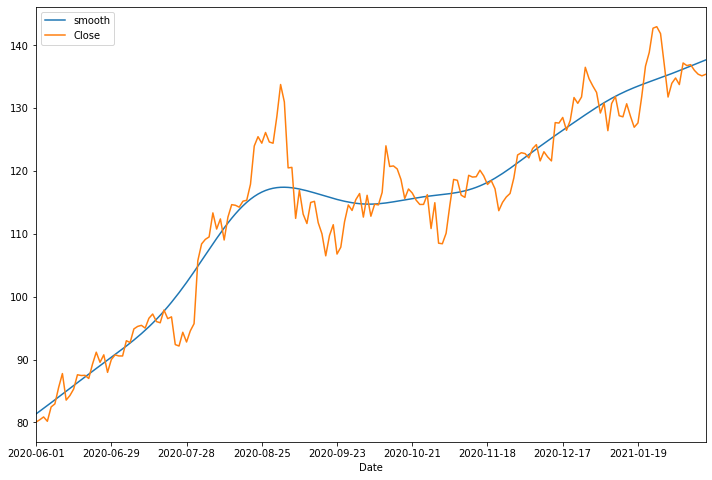

In [80]:
hist = pd.read_csv('/Users/frkornet/CDA/Project/stockie/data/yfin/AAPL.csv')
hist.index = hist.Date
hist[['smooth', 'Close', 'Date']].loc[hist.Date >= '2020-06-01'].plot(figsize=(12,8))
plt.savefig('/Users/frkornet/CDA/Project/docs/Final Report/smooth_vs_close.png')
plt.show()

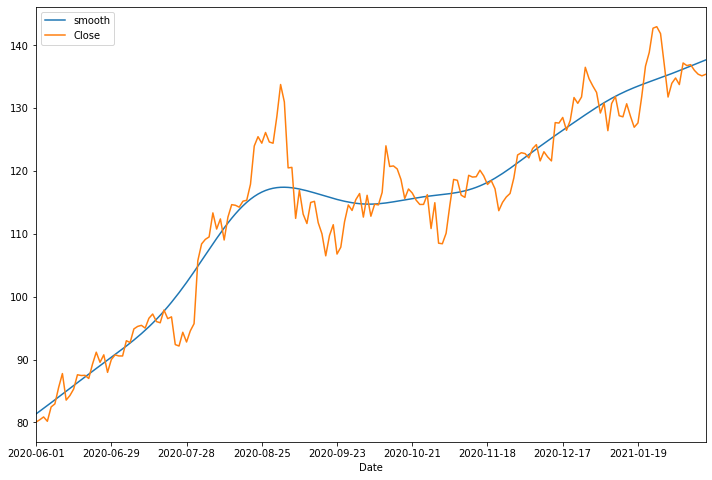

In [75]:
hist.plot(x='Date', figsize=(12,8))